In [31]:
datadir = "../data/"
datafilename_network = "Link_info_network_and_proj.xlsx"
datafilename_proj = 'Certainty.xlsx'
datafilepath_network = datadir + datafilename_network
datafilepath_proj = datadir + datafilename_proj

from itertools import combinations
import pandas as pd
import numpy as np
import math
import torch
from torch.utils.data import Subset
import wandb


# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="CGN to predict AADT",

#     # track hyperparameters and run metadata
#     config={
#      "hidden_layer_sizes": [12,24,48,64],
#     }
# )


In [32]:
network_cols_used = ['LINK','ANODE','BNODE','LENGTH','A X_COORD','A Y_COORD','B X_COORD','B Y_COORD','LANES_AB','LEFT_AB', 'RIGHT_AB','SPEED_AB','FSPD_AB','CAP_AB','LANES_BA','LEFT_BA','RIGHT_BA','SPEED_BA','FSPD_BA','CAP_BA'
]

# all 30000 links in the general network
df_network= pd.read_excel(datafilepath_network,sheet_name='Link_Info',usecols=network_cols_used).dropna(subset=['LINK'])

#650 links in the 6 projects
df_proj= pd.read_excel(datafilepath_network, sheet_name='Project_Links')


In [33]:
import networkx as nx

# Create a directed graph for the entire network
G_network = nx.DiGraph()

Anodes = df_network['ANODE'].tolist
Bnodes = df_network['BNODE'].tolist

# Add edges_ab with attributes
edges = [
    (row['ANODE'], row['BNODE'], {
        'length': row['LENGTH'],  
        '#lanes': row['LANES_AB'], 
        'speed': row['SPEED_AB'], 
        'FSPD': row['FSPD_AB'],
        'capacity': row['CAP_AB'],
        'Link ID': row['LINK'],
        'AADT Before': 0,
        'auto volume before': 0,
        'VMT before': 0
    })
    for _, row in df_network.iterrows()
]

# Add edges_ba only if lanes_ba != 0
edges += [
    (row['BNODE'], row['ANODE'], {
        'length': row['LENGTH'], 
        '#lanes': row['LANES_BA'], 
        'speed': row['SPEED_BA'], 
        'FSPD': row['FSPD_BA'],
        'capacity': row['CAP_BA'],
        'Link ID': row['LINK'],
        'AADT Before': 0,
        'auto volume before': 0,
        'VMT before': 0
    })
    for _, row in df_network.iterrows() if row['LANES_BA'] != 0
]

# List of pairs of integers that corresond to eges in project
proj_links = list(zip(df_proj['ANODE'], df_proj['BNODE']))


# Identifying edges in G_network that correspond to the list of pairs
# proj_edges = [(u, v) for u, v in proj_links if G_network.has_edge(u, v)]

# for project links, the "AADT Before","auto voulme before" and "VMT before" attributes are known and not zero
for i, item in enumerate(edges):
    if (edges[i][0], edges[i][1]) in proj_links:
        idx = proj_links.index((edges[i][0], edges[i][1]))
        edges[i][2]['AADT Before'] = df_proj.loc[idx]['AADT(2010)-B']
        edges[i][2]['auto volume before'] = df_proj.loc[idx]['auto volume(2010)-B']
        edges[i][2]['VMT before'] = df_proj.loc[idx]['VMT-B']
        
    


G_network.add_edges_from(edges)


# Creating the subgraph with only project edges
G_proj = G_network.edge_subgraph(proj_links)



In [34]:
# Now we create a directed line graph of the original network graph G_network
# In the line graph G_network_dual, each vertex corresponds to a directed edge in G_network
# Let uv, vw be two vertices in G_network_dual. (uv, vw) is a directed edge in G_network_dual iff (u,v), (v,w) are 
# two directed edges in G_network
# This is equivalent to say that each directed edge in G_network_dual corresponds to a length =2 directed path in G_network

G_network_dual = nx.line_graph(G_network) # dual graph of G_network
G_proj_dual = nx.line_graph(G_proj) # dual graph of G_proj


node_attrs = {}
for edge in G_network_dual.nodes:
    u, v = edge
    edge_data = G_network[u][v]  # Get the attributes of the edge from the original graph
    node_attrs[edge] = f"length: {edge_data['length']}, #lanes: {edge_data['#lanes']}, speed: {edge_data['speed']}, FSPD: {edge_data['FSPD']}, capacity: {edge_data['capacity']}, Link ID: {edge_data['Link ID']}, AADT Before: {edge_data['AADT Before']}, auto volume before: {edge_data['auto volume before']}, VMT before: {edge_data['VMT before']}"

# Convert dictionary to DataFrame
def parse_attributes(attr_string):
    attributes = {}
    for item in attr_string.split(', '):
        key, value = item.split(': ')
        attributes[key] = float(value)
    return attributes

# Create a DataFrame
df_node_attr_network = pd.DataFrame(
    [dict(**parse_attributes(value), index=key) for key, value in node_attrs.items()],
    index=[key for key in node_attrs.keys()]
)

# the dataframe that contains all node attributes in the dual network graph
df_node_attr_network = df_node_attr_network.iloc[:, :-1]

df_network_link_id = df_node_attr_network['Link ID']

# reorder columns of the data frame so that Link ID is the last column
df_node_attr_network = df_node_attr_network.iloc[:,[0,1,2,3,4,6,7,8,5]]

# df_node_attr_network = df_node_attr_network.drop(['Link ID'], axis = 1)

In [35]:
# Mapping node labels in G_network_dual, which are pairs of integers that coorespond to node labels in G_network,
# to the natural numbers 
node_mapping = {node: i + 1 for i, node in enumerate(G_network_dual.nodes())}
# Step 3: Construct a new graph with edges represented by mapped values
mapped_G_network_dual = nx.DiGraph()

# Add nodes with mapped attributes
for original_node in G_network_dual.nodes(data=True):
    original_label, attributes = original_node
    new_label = node_mapping[original_label]
    
    # Add the new node with the same attributes
    mapped_G_network_dual.add_node(new_label, **attributes)


# Add edges to the mapped graph using the new labels
for u, v in G_network_dual.edges():
    new_u = node_mapping[u]
    new_v = node_mapping[v]
    mapped_G_network_dual.add_edge(new_u, new_v)

# Identifying vertices in G_network_dual that correspond to links in G_proj
proj_nodes = [pair for pair in proj_links if pair in G_network_dual.nodes()]

# Keep the first occurrence of each unique element in proj_nodes
proj_nodes_unique = list(dict.fromkeys(proj_nodes))


In [36]:

from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F

node_attr_used = df_node_attr_network.columns[:-1]
# num_attr = len(node_attr_used)

num_attr = 7

num_node_label = 3

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(num_attr, hidden_channels)
        self.conv2 = GCNConv(hidden_channels,hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_attr)
        self.head = nn.Linear(num_attr, num_node_label)
        # add a multi-layer perceptron?
        # reference examples of using GNN for classification eg. citation network
        # can pretty much reuse all the previous layers (backbone) except for the last layer (layer head) which is specific to the application 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()

        x = self.conv2(x, edge_index)
        x = x.relu()

        x = self.conv3(x, edge_index)
        x = x.relu()
        
        x = self.head(x)
        
        return x

class MLP(nn.Module):
    def __init__(self, input_size= 64, output_size = 32, hidden=256):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden = hidden
        self.net = nn.Sequential(
            nn.Linear(self.input_size, self.hidden),
            nn.ReLU(),
            nn.Linear(self.hidden, self.output_size)
        )
        print("input size", self.input_size)
        print("output size", self.output_size)
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.00, std=0.01)

    def forward(self, y):
        return self.net(y)


In [37]:
# create a list of all sheet names

num_projs = 6
proj_list = list(range(1,num_projs+1))
def generate_combinations(proj_list):
    all_combinations = []
    # Loop through lengths from 1 to 6
    for length in range(1, 1+num_projs):
        # Generate combinations of the current length
        comb = combinations(proj_list, length)
        # Convert each combination to a string, add "p", and add to the list
        all_combinations.extend(['P' + ''.join(map(str, c)) for c in comb])
    return all_combinations
# Generate all combinations
sheet_names = generate_combinations(proj_list)

# Insert "P0" at the beginning of the list
# sheet_names.insert(0, "P0")


In [38]:
# import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# Scale all node attributes to be in the range of (0,1)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# scale each column with its own scaler
scaled_node_attr_network = np.zeros(df_node_attr_network.iloc[:,:-1].shape)
for ii in range(df_node_attr_network.iloc[:,:-(1+3)].shape[1]):
    scaler = MinMaxScaler()
    scaled_node_attr_network[:,ii:ii+1] = scaler.fit_transform(df_node_attr_network.iloc[:,ii:ii+1])

# put the scaled data into a dataframe
df_scaled_node_attr_network = pd.DataFrame(scaled_node_attr_network,index=df_node_attr_network.index, columns=node_attr_used)

# define a scaler that works for array of any length
def scaler_minmax(array):
    array = np.asarray(array, dtype = float)
    # mean = np.mean(array, axis=0)
    min = np.min(array, axis=0)
    # std = np.std(array, axis=0)
    max_minus_min = np.max(array,axis=0)-np.min(array,axis=0)

    scaled_array = (array-min)/max_minus_min
    return scaled_array, min, max_minus_min

# scale AADT_before, auto volume before, and vmt before
aadt_before_min = scaler_minmax(np.asarray(df_node_attr_network[df_node_attr_network['AADT Before']!=0]["AADT Before"], dtype = float))[1]
aadt_before_max_minus_min = scaler_minmax(np.asarray(df_node_attr_network[df_node_attr_network['AADT Before']!=0]["AADT Before"], dtype = float))[2]
auto_vol_before_min = scaler_minmax(np.asarray(df_node_attr_network[df_node_attr_network['auto volume before']!=0]["auto volume before"], dtype = float))[1]
auto_vol_before_max_minus_min = scaler_minmax(np.asarray(df_node_attr_network[df_node_attr_network['auto volume before']!=0]["auto volume before"], dtype = float))[2]
vmt_before_min = scaler_minmax(np.asarray(df_node_attr_network[df_node_attr_network['VMT before']!=0]["VMT before"], dtype = float))[1]
vmt_before_max_minus_min = scaler_minmax(np.asarray(df_node_attr_network[df_node_attr_network['VMT before']!=0]["VMT before"], dtype = float))[2]

aadt_before_array_scaled = (df_node_attr_network[df_node_attr_network['AADT Before']!=0]["AADT Before"]-aadt_before_min)/aadt_before_max_minus_min
df_scaled_node_attr_network["AADT Before"].loc[aadt_before_array_scaled.index] = aadt_before_array_scaled

auto_vol_before_array_scaled = (df_node_attr_network[df_node_attr_network['auto volume before']!=0]["auto volume before"]-auto_vol_before_min)/auto_vol_before_max_minus_min
df_scaled_node_attr_network["auto volume before"].loc[auto_vol_before_array_scaled.index] = auto_vol_before_array_scaled

vmt_before_array_scaled = (df_node_attr_network[df_node_attr_network['VMT before']!=0]["VMT before"]-vmt_before_min)/vmt_before_max_minus_min
df_scaled_node_attr_network["VMT before"].loc[vmt_before_array_scaled.index] = vmt_before_array_scaled


# TO unscale after training, use scaler.inverse_transform

df_scaled_node_attr_proj = df_scaled_node_attr_network.loc[list(G_proj_dual)]





/tmp/ipykernel_1411343/1240363625.py:40: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_scaled_node_attr_network["AADT Before"].loc[aadt_before_array_scaled.index] = aadt_before_array_scaled
/tmp/ipykernel_1411343/1240363625.py:43: FutureW

In [39]:

# Prepare the dataset 

proj_cols_used = ['Category','Link ID','ANODE','BNODE','A X_COORD','A Y_COORD','B X_COORD','B Y_COORD','Link Length(miles)','# of lanes-A','Capacity-A (veh/h)',
            'auto volume(2010)-A','AADT(2010)-B','AADT(2010)-A','Speed(mph)-A','VMT-A']
proj_features_used = ['']
dataset = []


# x = node features
# The entire network has node features
x = torch.from_numpy(df_scaled_node_attr_network.to_numpy(dtype=np.float32))
print(x.shape)


# edge index is shared among all samples
# Get the list of edges as tuples (source, target)
# the entire network has edge_index 
edges = list(mapped_G_network_dual.edges())

# Separate source and target nodes
source_nodes = [edge[0] for edge in edges]
target_nodes = [edge[1] for edge in edges]

# Create the edge_index tensor: shape [2, num_edges]
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)-1


for ii in range(len(sheet_names)):
    # read the correct sheet 
    df_sample= pd.read_excel(datafilepath_proj,sheet_name=sheet_names[ii],usecols=proj_cols_used).dropna(subset=['Link ID'])
    # df_sample = df_sample.astype('float64')

    # create a df to store scaled labels
    df_sample_label_scaled = pd.DataFrame(-1, index=df_sample.index, columns=['scaled AADT after','scaled auto volume after','scaled VMT after'])

    # scale AADT after, auto vol after and vmt after
    df_sample_label_scaled['scaled AADT after'] = (df_sample['AADT(2010)-A']-aadt_before_min)/aadt_before_max_minus_min
    df_sample_label_scaled['scaled auto volume after'] = (df_sample['auto volume(2010)-A']-auto_vol_before_min)/auto_vol_before_max_minus_min
    df_sample_label_scaled['scaled VMT after'] = (df_sample['VMT-A']-vmt_before_min)/vmt_before_max_minus_min
    
    


################################################################################
    # node attributes are defined by x above 
################################################################################   
    # # edge index
    # already defined as above
###################################################################################
    
    # Create the label tensor y
        
    # -1 for unlabeled nodes, correct class labels (positive real value) for labeled nodes in G_proj_dual
    # create a all -1 dataframe to store labels of the entire network
    df_scaled_labels_network = pd.DataFrame(-1, index = df_scaled_node_attr_network.index, columns = ['Link ID','scaled AADT after','scaled auto volume after','scaled VMT after'])
    network_links = list(G_network_dual.nodes)

    df_scaled_labels_network['Link ID'] = df_network_link_id

    for index in range(1, len(df_sample)+1):  # Loop through each row in df_sample
        # link_id = df_sample.loc[index, 'Link ID']  # Get 'Link ID' for the current row
        row_idx = list(zip([df_sample.loc[index]['ANODE']],[df_sample.loc[index]['BNODE']]))
    
    # Find the row in df_scaled_labels_network where 'Link ID' matches
        # row_idx = df_scaled_labels_network[df_scaled_labels_network['Link ID'] == link_id].index
    
        # if not row_idx.empty:  # If a match is found
        # Assign the value of 'AADT(2010)-A' from df_sample to 'AADT_after' in df_scaled_labels_network
        df_scaled_labels_network = df_scaled_labels_network.astype('float64')
        df_scaled_labels_network.loc[row_idx, 'scaled AADT after'] = df_sample_label_scaled.loc[index, 'scaled AADT after']
        df_scaled_labels_network.loc[row_idx, 'scaled auto volume after'] = df_sample_label_scaled.loc[index, 'scaled auto volume after']
        df_scaled_labels_network.loc[row_idx, 'scaled VMT after'] = df_sample_label_scaled.loc[index, 'scaled VMT after']



    
    y = torch.tensor(np.array(df_scaled_labels_network[['scaled AADT after','scaled auto volume after','scaled VMT after']]), dtype=torch.float)  

##################################################################################  
    # Create the train_mask so that training only happens on project links
    train_mask = pd.DataFrame(False, index = df_scaled_node_attr_network.index, columns = ['Masked'])

    row_idx = df_scaled_labels_network[df_scaled_labels_network['scaled AADT after'] != -1].index

    train_mask.loc[row_idx] = True


    # mask links that have >= 4 relative error for predicted AADT 
    # large_err_links = []
    # large_err_links = pd.Index(large_err_links)
    # train_mask.loc[large_err_links] = False


    train_mask = torch.tensor(train_mask.values, dtype=torch.bool)

    new_data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)


    # Append all 64 samples
    dataset.append(new_data)



torch.Size([56072, 8])


In [40]:
# create a boolean array to mask out any "Buffer" - related links
df_buffer_link_mask = pd.DataFrame(True, index = df_scaled_node_attr_network.index, columns = ['buffer links'])

buffer_link_id = df_sample[df_sample['Category'].str.contains('Buffer')]['Link ID']
buffer_link_row_idx = df_scaled_labels_network[df_scaled_labels_network['Link ID'].isin(buffer_link_id)].index

df_buffer_link_mask.loc[buffer_link_row_idx] = False



buffer_link_mask = torch.tensor(df_buffer_link_mask.values, dtype=torch.bool)

In [41]:
##### Split data in to Training, Validation, and Testing #####
num_samples = len(dataset)
# train_size = math.ceil(num_samples*0.7) # roughly 70% of the data is for training 
train_size = 4 
val_size = num_samples-train_size # roughly 30% of the data is for validation
# test_size = num_graphs-train_size-val_size # the rest is used for testing

# Create a list of indices
indices = list(range(num_samples))

# Shuffle the indices for randomness
# torch.manual_seed(42)  # For reproducibility
shuffled_indices = torch.randperm(num_samples).tolist()

# Split the indices into training, validation, and testing sets
train_indices = shuffled_indices[:train_size]
val_indices = shuffled_indices[train_size:train_size + val_size]
# test_indices = shuffled_indices[traind_size + val_size:]

# Create subsets for each split
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
# test_dataset = Subset(dataset, test_indices)

# print(train_dataset, val_dataset)

In [42]:
# define our data loader
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    
    def __init__(self,data):
        super().__init__()
        self.data = data

    def __len__(self):# number = 0
# for u, v, attrs in G_network.edges(data=True):
#     if attrs['AADT Before'] != 0:
#         number+=1
# print(number) 

# # type(proj_links)
# G_network.edge_subgraph(proj_links)
# sum(df_node_attr_network.loc[:,'auto volume before']>0)
# df_node_attr_network.loc[:,'auto volume before':'VMT before']
# df_node_attr_network
# sum(df_node_attr_network.loc[:,'VMT before']>0)
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]['x']
        edge_index = self.data[index]['edge_index']
        target = self.data[index]['y']
        return x, edge_index, target


train_dataset = CustomDataset(train_dataset)
val_dataset = CustomDataset(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    

In [43]:
print("validation indices:", val_indices)


validation indices: [46, 10, 39, 34, 8, 27, 17, 36, 61, 26, 11, 30, 45, 52, 51, 7, 40, 14, 32, 13, 28, 24, 56, 23, 60, 37, 20, 22, 38, 0, 15, 33, 9, 55, 48, 54, 3, 5, 57, 50, 2, 19, 62, 31, 18, 47, 25, 42, 53, 6, 1, 35, 41, 12, 29, 21, 44, 43, 49]


In [44]:
# Training settings


# num_attr_used_mlp = 3
# model = MLP(input_size = x.shape[0]*num_attr_used_mlp, output_size = x.shape[0]*3, hidden=x.shape[0]//64)

model = GCN(hidden_channels=24)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-4)
# criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss()

from timm.scheduler.cosine_lr import CosineLRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_steps_per_cycle = 1*10
warmup_steps = 1*1


# lr_scheduler = CosineLRScheduler(
#             optimizer,
#             t_initial= num_steps_per_cycle - warmup_steps,
#             t_mul=2.0,
#             lr_min=1e-6,
#             warmup_lr_init=1e-7,
#             warmup_t=warmup_steps,
#             t_in_epochs=False,
#             warmup_prefix=True,
#             cycle_limit = 0,
#         )

lr_scheduler = ReduceLROnPlateau(
                optimizer,
                patience = 45,
                factor = 0.8,
                min_lr = 1e-6
)


In [45]:
## SAVE MODEL
import os
if not os.path.exists("savedModels"):
    os.mkdir("savedModels")
    
def save_network(model, epoch_label):
    # save_filename = 'GCN model epoch_%d.pth' % (epoch_label)
    save_filename = 'MLP model epoch_%d.pth' % (epoch_label)
    save_path = os.path.join('./savedModels', save_filename)
    torch.save(model.state_dict(), save_path)

# modelfile = "./checkpoint.pth.tar"
# state = {"model_state": model.state_dict(),}
# torch.save(state, modelfile)




In [46]:
# We only train on proj links
combined_mask = train_mask & buffer_link_mask

output_indices = list(np.array(df_node_attr_network.index)[combined_mask.squeeze()])
# output_indices = list(np.array(df_node_attr_network.index)[train_mask.squeeze()])


proj_order_list = list(zip(df_sample[:]['ANODE'],df_sample[:]['BNODE']))
# print(proj_order_list)


#### I THINK THIS SORTING OF output_indices WORKS!!!!
sorted_output_indices = [item for item in proj_order_list if item in output_indices]

In [63]:


# Training loop
epochs = 20
previous_best_epoch_loss = 0.0 
best_epoch = 0    
# best_lr = lr



sum_target_2_norm_squared_overall = 0
sum_target_2_norm_squared_AADT = 0
# sum_target_2_norm_squared_autoVolume = 0
# sum_target_2_norm_squared_VMT = 0

df_AADT_prediction = pd.DataFrame(np.zeros((len(proj_order_list),len(train_indices))),columns = [sheet_names[i] for i in train_indices],index = proj_order_list)
# df_AADT_prediction = pd.DataFrame(columns = [sheet_names[i] for i in train_indices],index = sorted_output_indices)

for i, (x, edge_index, target) in enumerate(train_loader):

    target = target[0][buffer_link_mask.squeeze()]
    # target = target[0][train_mask.squeeze()]

    sum_target_2_norm_squared_overall += criterion(target, torch.zeros(target.shape))
    sum_target_2_norm_squared_AADT += criterion(target[:,0], torch.zeros(target[:,0].shape))
    
    # sum_target_2_norm_squared += criterion(target[train_mask.squeeze()], torch.zeros(len(target[train_mask.squeeze()])))

normalizing_const_ave_training_overall = sum_target_2_norm_squared_overall/len(train_loader)
normalizing_const_ave_training_AADT = sum_target_2_norm_squared_AADT/len(train_loader)


model.train()
for epoch in range(epochs):  # Adjust the number of epochs as needed
    epoch_loss = 0.0
    epoch_loss_AADT = 0.0
  
    for i, (x, edge_index, target) in enumerate(train_loader):
        
        optimizer.zero_grad()

        ###GCN
        # attributes used: length, #lanes, speed, capacity, aadt_before, auto_vol_before, vmt_before
        training_attr_tensor = torch.cat((x[0][:,:3],torch.unsqueeze(x[0][:,4],1), x[0][:,-3:]),1)
        out = model(training_attr_tensor, edge_index[0]).squeeze() 

        ### MLP
        # training_attr_tensor = x[0][:,-3:]
        # training_attr_tensor = torch.cat((x[0][:,:2],torch.unsqueeze(x[0][:,4],1), x[0][:,-3:]),1)
        # out = model(training_attr_tensor.flatten()).reshape(-1,3) # MLP 

        out = out[combined_mask.squeeze()]
        # out = out[buffer_link_mask.squeeze()]
        # out = out[train_mask.squeeze()]

        target = target[0][combined_mask.squeeze()]
        # target = target[0][buffer_link_mask.squeeze()]
        # target = target[0][train_mask.squeeze()]

        loss = criterion(out, target)
        loss_AADT = criterion(out[:,0], target[:,0])
        # loss.backward()
        loss_AADT.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_loss_AADT += loss_AADT.item()

        # print("out: ", out[:,0:1][train_mask.squeeze()])
        # print("target: ", target[0][train_mask.squeeze()][:,0])
        # print('learning rate:', optimizer.param_groups[0]["lr"])
        # print('loss_AADT: ', loss_AADT.item())
        
        if (i+1)%20 == 0:
            print('learning rate:', optimizer.param_groups[0]["lr"])

        # for Cos learning rate scheduler
        # lr_scheduler.step_update(epoch * len(train_loader) + i)
        lr_scheduler.step(loss_AADT)

        # df_AADT_prediction.iloc[:,i] = pd.DataFrame(out.detach()[:,0],index = output_indices).loc[sorted_output_indices]
        df_output = pd.DataFrame(out.detach()[:,0],index = output_indices).loc[output_indices]
        df_AADT_prediction.loc[df_output.index,df_AADT_prediction.columns[i]] = df_output.iloc[:,0]
    
    print('epoch loss AADT: ', epoch_loss_AADT)    
    absolute_mse_ave_training = epoch_loss/len(train_loader)
    absolute_mse_AADT_ave_training = epoch_loss_AADT/len(train_loader)
    print(f'\nEpoch {epoch + 1}, Absolute MSE: {format(absolute_mse_ave_training,".2e")}')
    print(f'\nEpoch {epoch + 1}, Absolute AADT MSE: {format(absolute_mse_AADT_ave_training,".2e")}')

    relative_loss_overall = absolute_mse_ave_training/normalizing_const_ave_training_overall
    relative_loss_AADT = absolute_mse_AADT_ave_training/normalizing_const_ave_training_AADT
    print(f"Relative Loss (Overall) = {absolute_mse_ave_training:.2e} / {normalizing_const_ave_training_overall:.2e} = {relative_loss_overall:.2e}")
    print(f"Relative Loss (AADT) = {absolute_mse_AADT_ave_training:.2e} / {normalizing_const_ave_training_AADT:.2e} = {relative_loss_AADT:.2e}")

    
    if epoch == 0:
        previous_best_epoch_loss_AADT = epoch_loss_AADT
        best_epoch = epoch
        print(previous_best_epoch_loss_AADT, epoch_loss_AADT)
    elif (epoch+1)%3 == 0 and epoch_loss_AADT < previous_best_epoch_loss_AADT:
        print('saving epoch', epoch)
        best_epoch = epoch
        previous_best_epoch_loss_AADT = epoch_loss_AADT
        save_network(model, epoch+1)
    
    # log metrics to wandb
#     wandb.log({"absolute training set mse": absolute_mse_ave_training, "relative training set mse": relative_loss})

# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()



epoch loss AADT:  1.2217913120985031

Epoch 1, Absolute MSE: 9.94e-01

Epoch 1, Absolute AADT MSE: 3.05e-01
Relative Loss (Overall) = 9.94e-01 / 9.99e-01 = 9.95e-01
Relative Loss (AADT) = 3.05e-01 / 9.99e-01 = 3.06e-01
1.2217913120985031 1.2217913120985031
epoch loss AADT:  1.2216920256614685

Epoch 2, Absolute MSE: 9.94e-01

Epoch 2, Absolute AADT MSE: 3.05e-01
Relative Loss (Overall) = 9.94e-01 / 9.99e-01 = 9.95e-01
Relative Loss (AADT) = 3.05e-01 / 9.99e-01 = 3.06e-01
epoch loss AADT:  1.2229455262422562

Epoch 3, Absolute MSE: 9.95e-01

Epoch 3, Absolute AADT MSE: 3.06e-01
Relative Loss (Overall) = 9.95e-01 / 9.99e-01 = 9.96e-01
Relative Loss (AADT) = 3.06e-01 / 9.99e-01 = 3.06e-01
epoch loss AADT:  1.2212049216032028

Epoch 4, Absolute MSE: 9.95e-01

Epoch 4, Absolute AADT MSE: 3.05e-01
Relative Loss (Overall) = 9.95e-01 / 9.99e-01 = 9.96e-01
Relative Loss (AADT) = 3.05e-01 / 9.99e-01 = 3.06e-01
epoch loss AADT:  1.2212102860212326

Epoch 5, Absolute MSE: 9.95e-01

Epoch 5, Absolu

In [19]:
# # df_AADT_prediction.loc[output_indices].iloc[:,i] = pd.DataFrame(out.detach()[:,0],index = output_indices).loc[output_indices]
# # df_AADT_prediction.iloc[:,i][df_AADT_prediction.iloc[:,i].notna()]
# # df_pred_filtered.iloc
# # pd.DataFrame(out.detach()[:,0],index = output_indices)
# # first_col = df_AADT_prediction.iloc[:,i]
# # first_col.dropna()
# df_output = pd.DataFrame(out.detach()[:,0],index = output_indices).loc[output_indices]
# df_AADT_prediction.loc[df_output.index,df_AADT_prediction.columns[i]] = df_output.iloc[:,0]
# # df_AADT_prediction.loc[df_output.index,df_AADT_prediction.columns[i]] 
# # df_AADT_prediction
# # df_AADT_prediction.loc[output_indices,df_AADT_prediction.columns[i]]
# # pd.DataFrame(out.detach()[:,0],index = output_indices).loc[output_indices]
# df_AADT_prediction.iloc[:,i].dropna()

In [20]:
# # df_AADT_prediction.iloc[:,i] = pd.DataFrame(out.detach()[:,0],index = output_indices).loc[sorted_output_indices]
# df_out = pd.DataFrame(out.detach()[:,0],index = output_indices)
# df_AADT_prediction.iloc[:,i].loc[df_out.index]
# all(x in df_AADT_prediction.iloc[:,i].index for x in df_out.index)
# df_node_attr_network
# all(x in proj_order_list for x in row_idx)
# len(df_AADT_prediction.index)
# df_sample
# proj_order_list
# df_node_attr_network

In [21]:

# # # Filter df1 to keep only rows where ls1 values are in index
# # df_filtered = df1[df1['ls1'].isin(index)]

# # # Reorder based on index order
# # df_filtered = df_filtered.set_index('ls1').reindex(index).reset_index()
# # AADT_predicted.reindex(AADT_before.index, fill_value=0)

# AADT_predicted_augmented = AADT_before.copy().to_frame(name="values")  # Start with s1's structure
# AADT_predicted_augmented['values'] = 0  # Fill all values with 0 initially

# # AADT_predicted_augmented.loc[AADT_predicted.index,'values'] = AADT_predicted  # Assign values from s2\
# # type(AADT_predicted_augmented)

# for idx in AADT_predicted_augmented.index:
#     if idx in AADT_predicted.index:  # Check if the index exists in df
#         # find the sub data frame with matching indices 
#         rows_to_update = AADT_predicted_augmented.loc[[idx]]
#         for ii in range(len(rows_to_update)):
#             # AADT_predicted_augmented.loc[[idx]].iloc[ii]['values'] 
#             aadt_predicted_value = AADT_predicted.loc[[idx]].values[0] 
#             rows_to_update.iloc[ii]['values'] = aadt_predicted_value
#             # rows_to_update.iloc[ii]['values'] = 23
#         AADT_predicted_augmented.loc[[idx]] = rows_to_update

# ##### TRYING TO AUGMENT AADT_predicted so that it has 650 links, with the non-proj links having a zero predicted value 
# AADT_predicted_augmented




In [105]:
# unscaled plot
# select a sample
sample_to_plot = 2
sample_to_plot = df_AADT_prediction.columns[sample_to_plot]
df_sample_plot= pd.read_excel(datafilepath_proj,sheet_name=sample_to_plot,usecols=proj_cols_used).dropna(subset=['Link ID'])
# df_sample_plot = df_sample_plot.astype('float64')

AADT_before = df_sample_plot['AADT(2010)-B']

AADT_after = df_sample_plot['AADT(2010)-A']

AADT_predicted = pd.DataFrame(np.zeros((len(AADT_after),1)),columns = [sample_to_plot],index = AADT_after.index)
for i, item in enumerate(df_AADT_prediction[sample_to_plot]): 
    if item !=0:
        AADT_predicted.iloc[i] = item*aadt_before_max_minus_min + aadt_before_min
# AADT_predicted = AADT_predicted.set_axis(AADT_before.index)

# AADT_before_index = list(zip(df_sample_plot['ANODE'], df_sample_plot['BNODE']))
# AADT_before.index = AADT_before_index
# AADT_after.index = AADT_before_index

# AADT_before_proj_only = AADT_before[AADT_before.index.isin(AADT_predicted.index)]
# AADT_after_proj_only = AADT_after[AADT_after.index.isin(AADT_predicted.index)]

# AADT_before_proj_only = AADT_before_proj_only.reindex(AADT_predicted.index)
# AADT_after_proj_only = AADT_after_proj_only.reindex(AADT_predicted.index)


# AADT_predicted = AADT_predicted.set_axis(AADT_before.index)


In [104]:
# scaled plot
# select a sample
sample_to_plot = 2
sample_to_plot = df_AADT_prediction.columns[sample_to_plot]
df_sample_plot= pd.read_excel(datafilepath_proj,sheet_name=sample_to_plot,usecols=proj_cols_used).dropna(subset=['Link ID'])
# df_sample_plot = df_sample_plot.astype('float64')

AADT_before = df_sample_plot['AADT(2010)-B']
AADT_before = (AADT_before-aadt_before_min)/aadt_before_max_minus_min

AADT_after = df_sample_plot['AADT(2010)-A']
AADT_after = (AADT_after-aadt_before_min)/aadt_before_max_minus_min

# AADT_predicted = df_AADT_prediction[sample_to_plot]*aadt_before_max_minus_min + aadt_before_min
AADT_predicted = df_AADT_prediction[sample_to_plot]
AADT_predicted = AADT_predicted.set_axis(AADT_before.index)


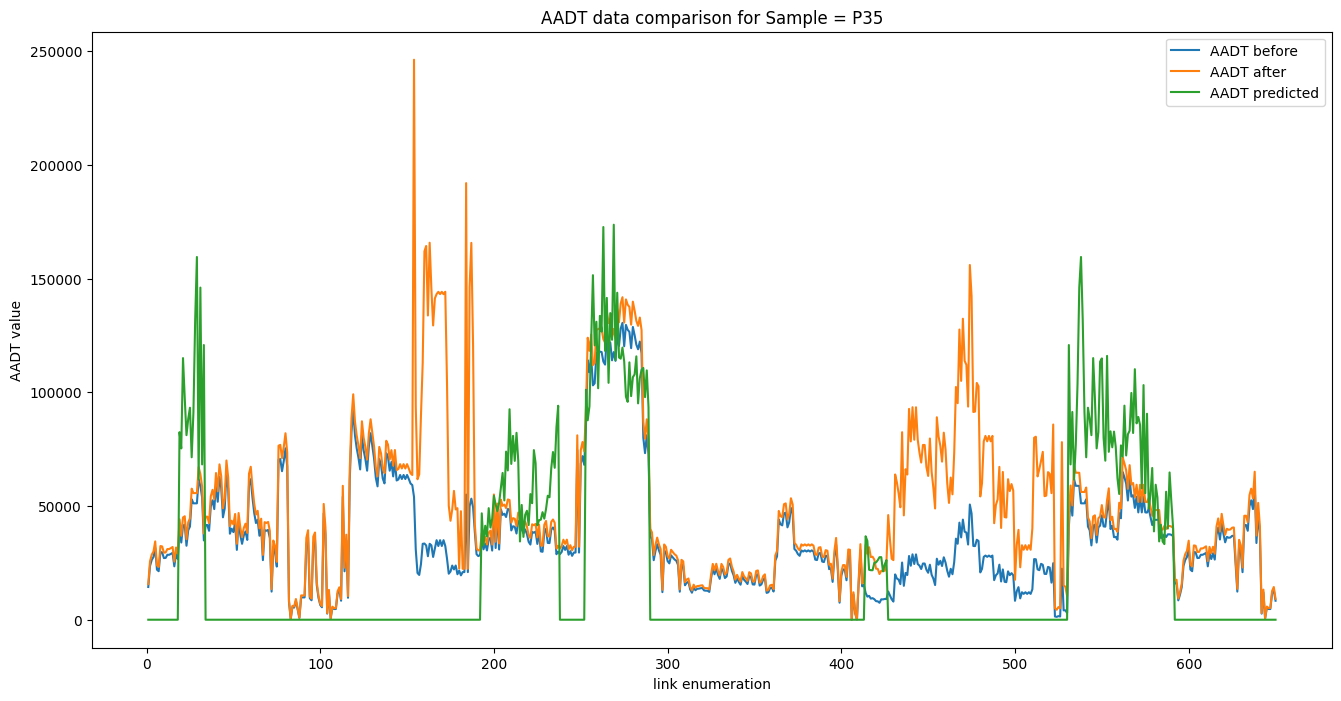

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize= (16, 8))

# Plot the Series
plt.plot(AADT_before, label='AADT before')
plt.plot(AADT_after, label='AADT after')
plt.plot(AADT_predicted, label='AADT predicted')

# Add labels and title
plt.xlabel('link enumeration')
plt.ylabel('AADT value')
plt.title(f'AADT data comparison for Sample = { sample_to_plot}')


# Add legend
plt.legend()

# Show the plot
plt.show()

In [144]:
# compute the RMSE(root mean squared loss)

# create a boolean array to only include links whith non-zero AADT_predicted
rmse_idx = np.zeros(len(AADT_predicted))
for i, item in enumerate(AADT_predicted.values):
    if item!=0:
        rmse_idx[i] = 1

rmse = np.sqrt(np.sum(np.square(AADT_after[rmse_idx!=0].values - AADT_predicted[AADT_predicted.values!=0].values))/len(rmse_idx[rmse_idx!=0]))

rmse_normalizing_constant = np.sqrt(np.sum(np.square(AADT_after[rmse_idx!=0].values))/len(rmse_idx[rmse_idx!=0]))

relative_rmse = rmse/rmse_normalizing_constant

print('RMSE= ', rmse)
print(f"Relative RMSE = {rmse} / {rmse_normalizing_constant} = {relative_rmse}")





RMSE=  673392.9812659698
Relative RMSE = 673392.9812659698 / 71064.00488819892 = 9.475865908843469


In [20]:
# # # xx = torch.rand(2)
# # # print(xx)
# # # print(torch.norm(xx, p=2).item()**2/2)
# # # print(criterion(xx, torch.zeros(2)))
# # # # print(criterion(target[0][train_mask.squeeze()],torch.zeros(len(target[0][train_mask.squeeze()]))))
# # criterion(target[0][train_mask.squeeze()], torch.zeros(len(target[0][train_mask.squeeze()])))
# # # len(train_loader)\
# sum_target_2_norm_squared = 0
# for i, (x, edge_index, target) in enumerate(train_loader):
#     sum_target_2_norm_squared += criterion(target[0][train_mask.squeeze()], torch.zeros(len(target[0][train_mask.squeeze()])))

# normalizing_const_ave_training = sum_target_2_norm_squared/len(train_loader)
# print(normalizing_const_ave_training)

In [21]:
# Check that we have correctly created the line graph

# print some node labels 
# for node, label in node_labels.items():
#     print(f"Node {node}: {label}")

# # Print a couple of edges and their attributes from the original graph
# print("Sample edges from the original graph with attributes:")
# for u, v, data in list(G_network.edges(data=True))[:5]:  # Print the first 5 edges as an example
#     print(f"Edge ({u}, {v}): {data}")

# # Print a few nodes and their attributes from the line graph
# print("Sample nodes in the line graph with their labels:")
# for node in list(G_network_dual.nodes)[:5]:  # Print the first 5 nodes as an example
#     print(f"Node {node}: {node_labels[node]}")


In [22]:


# import networkx as nx
# 
# # Create a directed graph
# G = nx.DiGraph()

# # Add nodes
# G.add_nodes_from([1, 2, 3, 4])

# # Add edges with attributes
# G.add_edge(1, 2, weight=5)
# G.add_edge(2, 3, weight=3)
# G.add_edge(3, 4, weight=7)
# G.add_edge(4, 1, weight=2)
# G.add_edge(2, 4, weight=4)

# # # Display the edges with attributes
# # for u, v, data in G.edges(data=True):
# #     print(f"Edge from {u} to {v} with attribute: {data}")



# H = nx.line_graph(G)

# node_labels = {}
# for edge in H.nodes:
#     u, v = edge
#     node_labels[edge] = G[u][v]['weight']  # Get the weight from the original graph




# # Optionally, draw the graph
# import matplotlib.pyplot as plt

# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True, node_color='lightblue', arrows=True)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


# plt.show()

# posH = nx.spring_layout(H)
# nx.draw(H, posH, with_labels=True, node_color='lightgreen',arrows=True)

# # Draw the node labels (weights from the original graph)
# nx.draw_networkx_labels(H, posH, labels=node_labels, font_color='red')



# plt.show()





In [23]:
# import itertools

# # find the 650 links in the network based on link ID
# proj_link_index = df_proj['Link ID'].apply(lambda x: df_network.index[df_network['LINK'] == x].to_list()).to_list()

# proj_link_index=list(itertools.chain.from_iterable(proj_link_index))

# # check if Anodes are the same
# Anode_same = np.all(df_network['ANODE'].iloc[proj_link_index].to_numpy() - df_proj['ANODE'].to_numpy()==0)

# # check if Bnodes are the same
# Bnode_same = np.all(df_network['BNODE'].iloc[proj_link_index].to_numpy() - df_proj['BNODE'].to_numpy()==0)

# # check if length are the same
# length_same = np.all(df_network['LENGTH'].iloc[proj_link_index].to_numpy() - df_proj['Link Length(meter)'].to_numpy()==0)

# A_X_Cord_same = np.all(df_network['A X_COORD'].iloc[proj_link_index].to_numpy() - df_proj['A X_COORD'].to_numpy()==0)
# A_Y_Cord_same = np.all(df_network['A Y_COORD'].iloc[proj_link_index].to_numpy() - df_proj['A Y_COORD'].to_numpy()==0)
# B_X_Cord_same = np.all(df_network['B X_COORD'].iloc[proj_link_index].to_numpy() - df_proj['B X_COORD'].to_numpy()==0)
# B_Y_Cord_same = np.all(df_network['B Y_COORD'].iloc[proj_link_index].to_numpy() - df_proj['B Y_COORD'].to_numpy()==0)


# # verify that all the A_node, B_note, length info about the project links are consistant across the two data files 
# print("Is it true that A_node, B_note, length info about the project links are consistant across the two data files? \n", Anode_same, Bnode_same, length_same)
# print(A_X_Cord_same, A_Y_Cord_same, B_X_Cord_same, B_Y_Cord_same)